In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 7

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2024-02-21 15:54:55.203274: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/5 [=====>........................] - ETA: 1s - loss: 1.9890 - accuracy: 0.1562
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 1s 88ms/step - loss: 1.9802 - accuracy: 0.1633 - val_loss: 1.9403 - val_accuracy: 0.1970
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.9782 - accuracy: 0.1875
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 0s 35ms/step - loss: 1.9788 - accuracy: 0.1616 - val_loss: 1.9164 - val_accuracy: 0.2475
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.9905 - accuracy: 0.1172
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 0s 15ms/step - loss: 1.9421 - accuracy: 0.1818 - val_loss: 1.8985 - val_accuracy: 0.2576
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.9128 - accuracy: 0.2109
Epoch 4: saving model to 

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.9798


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 82ms/step
[8.9869238e-03 2.7444493e-03 2.5115126e-01 6.8655383e-04 6.9789769e-04
 8.8367667e-03 7.2689611e-01]
6


# 混同行列

7/7 [==============================] - 0s 683us/step


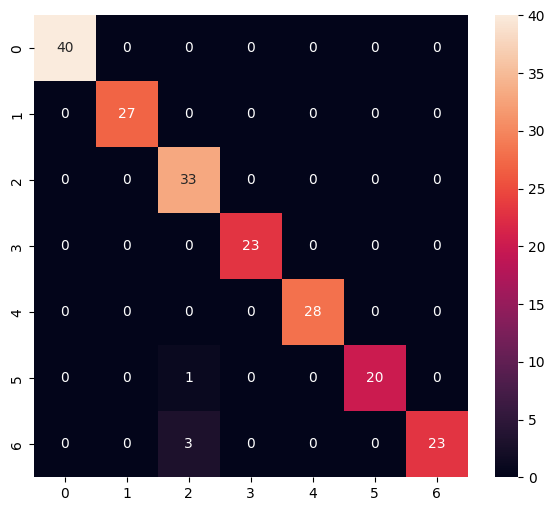

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        27
           2       0.89      1.00      0.94        33
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        28
           5       1.00      0.95      0.98        21
           6       1.00      0.88      0.94        26

    accuracy                           0.98       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.98      0.98      0.98       198



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/tw/m5jjpxsn1013b05mh1nh3m100000gn/T/tmpqp85uhdr/assets


2024-02-21 15:55:17.621587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-21 15:55:17.621607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


6676

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 4 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions for the whole graph.
INFO: Successfully applied the default TensorFlow Lite delegate indexed at 0.
 *NOTE*: because a delegate has been applied, the precision of computations should be unchanged, but the exact output tensor values may have changed. If such output values are checked in your code, like in your tests etc., please consider increasing error tolerance for the check.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 271 µs, sys: 264 µs, total: 535 µs
Wall time: 355 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.9869257e-03 2.7444486e-03 2.5115108e-01 6.8655401e-04 6.9789722e-04
 8.8367686e-03 7.2689629e-01]
6
